# Set Up

In [1]:
%%capture
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Numpy array de embeddings de imagenes
!wget https://www.dropbox.com/scl/fi/rd8xxbz8duqp7s3nkzylv/imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2&st=9mn8cev0&dl=0
!mv imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2 imgs_features.npy
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz
# CSV de restaurantes
!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=fqh0067i&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv
# CSV de reviews
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# TINY LLaVA Descriptions json.gz
!wget https://www.dropbox.com/scl/fi/50pmwvytozpz0cl1p054f/tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk&st=9568qz84&dl=0
!mv tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk tiny_LLaVa_images_descriptions.json.gz

# Libraries

In [2]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch
from tqdm import tqdm
from collections import Counter
from itertools import combinations

In [12]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Data Preprocessing

In [13]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [14]:
X = df[['user_id', 'rest_id', 'rating']]

In [15]:
restaurants = pd.read_csv('restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-15-0a147b4e1a57>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [16]:
restaurants.index

RangeIndex(start=0, stop=7044, step=1)

In [17]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [18]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [19]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [20]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [21]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

# Utils


Las siguientes funciones para analizar el perfil de un usuario fueron realizadas en conjunto con ChatGPT. Comparto la siguiente sesion del Chat.
https://chatgpt.com/share/6754f91c-9c08-800e-879a-b2bb5c5241aa

In [22]:
def limpiar_texto(texto):
    # Quitar caracteres especiales y convertir a minúsculas
    texto_limpio = re.sub(r'[^\w\s]', '', texto.lower())
    return texto_limpio

def obtener_palabras_clave(comentarios):
    vectorizador = TfidfVectorizer(max_features=20, stop_words='english')
    X = vectorizador.fit_transform(comentarios)
    palabras_clave = vectorizador.get_feature_names_out()
    return palabras_clave

def analizar_sentimientos(comentarios):
    sia = SentimentIntensityAnalyzer()
    resultados = []
    for comentario in comentarios:
        score = sia.polarity_scores(comentario)
        sentimiento = "positive" if score['compound'] > 0 else "negative" if score['compound'] < 0 else "neutral"
        resultados.append({
            "comentario": comentario,
            "sentimiento": sentimiento,
            "score": score['compound']
        })
    return resultados

def analyse_user_profile(comentarios):
    comentarios_limpios = [limpiar_texto(c) for c in comentarios]

    # Palabras clave y temas
    palabras_clave = obtener_palabras_clave(comentarios_limpios)

    # Sentimientos
    analisis_sentimientos = analizar_sentimientos(comentarios)
    sentimientos = [a["sentimiento"] for a in analisis_sentimientos]

    perfil = {
        "keywords": palabras_clave,
        "dominant_sentiment": max(set(sentimientos), key=sentimientos.count)
    }

    return perfil

In [99]:
def get_user_profile(uid):
    '''Funcion que retorna diferentes aspectos de un usuario en base a su id.
    Entre estos retornamos tanto sus sentimientos y gustos en base a sus reviews.
    Ademas, de las caracteristicas de los restaurantes visitados por el (ambiente,
    tipo de restaurante, entre otros).'''
    # Lista de ids de cada review (restaurantes ya calificados)
    curr_user_reviews_ids = [item for item in train_users[uid]]
    curr_user_reviews_info = df.loc[curr_user_reviews_ids].to_dict('index').values()
    # Lugares visitados
    places_visited = set(rev['state'] for rev in curr_user_reviews_info)

    # Analisis del perfil del usuario
    user_comments = [rev['text'] for rev in curr_user_reviews_info]
    profile = analyse_user_profile(user_comments)

    # Caracteristicas de los restaurantes visitados
    rests_offerings = [restaurants_dict[rev['rest_id']]['offerings']
                       for rev in curr_user_reviews_info
                       if restaurants_dict[rev['rest_id']]['offerings'] is not np.nan]
    rests_offerings = list({item
                        for row in [phrase.split(';') for phrase in rests_offerings]
                        for item in row})

    # Categorias de los restaurantes visitados
    rests_categories = [restaurants_dict[rev['rest_id']]['categories']
                       for rev in curr_user_reviews_info]
    rests_categories = {item
                        for row in [phrase.split(';') for phrase in rests_categories]
                        for item in row
                        if item != 'Restaurant'}

    print('Perfil del usuario'.upper())
    print('- Palabras claves:')
    for i in range(0, len(profile['keywords']), 5):
        print('  ', f', '.join(profile['keywords'][i:i+5]))

    print('- Sentimiendo dominante: ', profile['dominant_sentiment'])

    print('- Lugares visitados: ', ', '.join(places_visited))
    print('- Caracteristicas de restaurantes visitados:')
    for i in range(0, len(rests_offerings), 5):
        print('  ', f', '.join(rests_offerings[i:i+5]))


In [24]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users

def get_relevant_items(user):
    user_reviews = test_user_items[user]
    user_reviews = list(
        map(lambda x: x[0],
        filter(lambda x: x[1] >= 3.5, user_reviews)
    ))
    return user_reviews

def MAP(model_reclist, n):
    mean_ap = 0.
    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
    mean_ap /= len(test_users)
    return mean_ap

def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        #user_reviews = test_users[u]


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(test_users)
    mean_ndcg /= len(test_users)
    mean_recall /= len(test_users)
    mean_precission /= len(test_users)
    mean_rr /= len(test_users)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



In [73]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    get_user_profile(user)
    print(f'\n{len(reclist)} recomendaciones'.upper())
    return reclist_df


# Models

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [26]:
print(torch.cuda.is_available())

False


El siguiente modelo solo lo debemos exportar si es que queremos extraer caracteristicas de una imagen. Estas ya se encuentran descargadas en el archivo  Tiny_LLaVa_descriptions.json.gz

In [27]:
# Importamos los modelos a usar
# LLaVa

model_id = "bczhou/tiny-llava-v1-hf"
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [28]:
# all-MiniLM-L6-v2
'''Sentence transformers AllMiniLM para codificar las descripciones hecha por
LLaVA'''
encoder = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Generate Imgs Descriptions

In [29]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

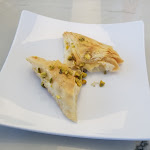

In [31]:
# Ejemplo de output en base al prompt entregado.
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
# Se debe tener activado GPU para usar el modelo.
# get_description(image)  # [Descomentar si es necesario]

El siguiente codigo no es necesario ejecutarlo. Es para extraer las descripciones. Toma 2 horas.

In [ ]:
images = [Image.open(f'reviews/{row.img_filename}').resize((128, 128)) for _, row in df.iterrows()]

In [ ]:
# Genera descripciones de imágenes en lotes y evita sobrecargar la GPU.
def batch_generate_descriptions(images):
    messages = ["What's in the picture? Give me a brief summary" for _ in images]
    prompts = [f"USER: <image>{message}\nASSISTANT:" for message in messages]

    inputs = processor(prompts, images=images, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
    generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)

    descriptions = [text.split("ASSISTANT: ")[-1] for text in generated_texts]
    return descriptions


In [ ]:
def save_images_descriptions(df):
    img_description = {}
    batch_size = 16
    image_batch = []
    filenames = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
        img = Image.open(f'{PREFIX}/{row.img_filename}').resize((128, 128))
        image_batch.append(img)
        filenames.append(row.img_filename)

        # Procesamos el batch cuando alcanza el tamaño especificado ...
        if len(image_batch) == batch_size:
            descriptions = batch_generate_descriptions(image_batch)
            img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
            image_batch.clear()
            filenames.clear()
            torch.cuda.empty_cache()

    # procesamos las imgs restantes
    if image_batch:
        descriptions = batch_generate_descriptions(image_batch)
        img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
        torch.cuda.empty_cache()

    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)


In [ ]:
save_images_descriptions(df)

Processing rows: 100%|██████████| 8038/8038 [2:07:17<00:00,  1.05it/s]


## Download Imgs Descriptions

In [32]:
imgs_descriptions = list(parse("tiny_LLaVa_images_descriptions.json.gz"))[0]

In [33]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384. Toma entre 2 a 3 minutos la ejecucion.
for key, value in tqdm(imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)


100%|██████████| 8038/8038 [03:01<00:00, 44.22it/s]


In [34]:
rev_embeddings = {}
for img_filename, emb in imgs_embeddings.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_embeddings[rev_id] = emb

In [35]:
rev_descriptions = {}
for img_filename, description in imgs_descriptions.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_descriptions[rev_id] = description


In [36]:
rev_id2info = X.to_dict('index')

In [37]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

In [38]:
allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))

In [39]:
print(len(user_reviews.keys()))

7254


In [40]:
print(allreviews.min())
print(allreviews.mean())
print(allreviews.max())

1
1.1080783016266886
10


In [41]:
count_reviews = Counter(allreviews)
for k, v in sorted(count_reviews.items(), key=lambda x: x[0]):
    print(f'{k:<2} {v:>5}')

1   6700
2    423
3     79
4     27
5     13
6      7
7      3
9      1
10     1


Por cada review de un usuario, creamos el set de train y el de test.
En el caso que un usuario tiene mas de una review, dejamos el 20% de las reviews para test y el resto para train (esto permite que el usuario tenga reviews tanto en testing como en training).
En el otro caso, si el usuario no tiene mas de 1 review, entonces lo dejamos para "entrenar el modelo", ya que no podriamos saber mas info.

In [42]:
train_set, test_set = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        train_set.append(reviews)
    else:
        if 1 < len(reviews) <= 3:           # 2 o 3 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:         # 4 o 5 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:                               # 6 o + reviews
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)
        train_set.append(train_data)
        test_set.append(test_data)

In [43]:
x_train, x_test = [], []
for d in train_set:
    x_train.extend(d)
for d in test_set:
    x_test.extend(d)

> (review ID, restaurant ID, review's rating, restaurant categories ID)

In [44]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [45]:
x_train[0]

(0, 3818, 5, 0)

In [46]:
train_embeddings = list(map(lambda x: rev_embeddings[x[0]], x_train))

In [47]:
test_users = {}
for x in x_test:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not test_users.get(user_id):
        test_users[user_id] = []
    test_users[user_id].append(rev_id)


In [48]:
train_users = {}
for x in x_train:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']

    if not train_users.get(user_id):
        train_users[user_id] = []

    train_users[user_id].append(rev_id)

## Training functions

In [52]:
def get_test_embedding(user_id, reviews, mode='knn'):
    '''Funcion que entrega el embedding de testing de un usuario bajo los metodos
    Mean o MostSimilar

    @input: Obtenemos el id de un usuario y los ids de sus reviews realizadas
    '''

    # Si el usuario solo hizo una review en testing, entonces retornamos el embedding de solo esa review.
    if len(reviews) <= 1:
        rev_id = reviews[0]

        return rev_embeddings[rev_id]

    # Si hizo al menos 2 reviews, usamos similitud del coseno para ver que review de testing
    # es la que presenta mayor similitud con las reviews del training.
    # Escogemos la review con la similitud mas alta.

    user_train_revs = train_users[user_id]  # Reviews realizadas por el usuario (train)
    user_test_revs = reviews                # Reviews de testing del usuario (por predecir)

    user_train_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_train_revs))

     # En el caso que sea mean, retornamos el promedio de las reviews de train
    if mode == 'mean':
        user_test_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_test_revs))
        return np.mean(user_test_embeddings, axis=0)


    max_sim_test_idx = -1                   # Indice de la review de testing que tiene maxima similitud
    max_sim_value = -1                      # Valor de similitud maximo alcanzado

    for test_idx, rev_id in enumerate(user_test_revs):
        user_test_embedding = rev_embeddings[rev_id]

        similarities = encoder.similarity(user_test_embedding, user_train_embeddings).cpu().numpy()[0]
        max_curr_sim = similarities.mean()

        if max_sim_value < max_curr_sim:
            max_sim_value = max_curr_sim    # actualizamos el valor mas alto de similitud
            max_sim_test_idx = test_idx     # actualizamos el indice del test embedding con mas similitud


    # Escogemos el embedding con maxima similitud.

    best_id = user_test_revs[max_sim_test_idx]
    best_test_embedding = rev_embeddings[best_id]

    return best_test_embedding

In [50]:
# Retorna la lista de recomendaciones
def llava_train(train_users, test_users, mode='knn', k_values=[10, 20]):
    llava_reclists = {}

    for user_id, reviews in tqdm(test_users.items(), desc="Procesando ... "):
        llava_reclists[user_id] = { k : [] for k in k_values }
        test_embedding = get_test_embedding(user_id, reviews, mode)

        # Realizamos "KNN" para buscar los embeddings del training mas cercanos con
        # respecto al embedding de testing

        similarities = encoder.similarity(test_embedding, train_embeddings).cpu().numpy()[0]

        # Ordenamos de mayor a menor.

        sorted_idxs = similarities.argsort()[::-1]

        # Aca realizamos el KNN-k, con k en {10, 20}.
        for k in k_values:
            recommended_restaurants_k = []

            for idx in sorted_idxs:
                rest_id = x_train[idx][1] # Rest ID

                # Como son reviews, pueden ser del mismo restaurant -> Aseguramos no duplicados
                if rest_id not in recommended_restaurants_k:
                    recommended_restaurants_k.append(rest_id)
                    llava_reclists[user_id][k].append(rest_id)

                if len(recommended_restaurants_k) == k:
                    break
    # Guardamos la lista de recomendaciones
    with gzip.open("LLaVa_users_reclists.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(llava_reclists, zipfile)

    return llava_reclists


In [51]:
test_user_items = {} # Usuario de testing y restaurantes evaluados ...
for user, reviews in test_users.items():
    test_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

# Sensitivity analysis

In [53]:
k_values = [5, 10, 20, 30, 50]
llava_most_sim_reclist = llava_train(train_users, test_users, mode='knn', k_values=k_values)

Procesando ... :   0%|          | 0/554 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  a = torch.tensor(a)
Procesando ... : 100%|██████████| 554/554 [02:41<00:00,  3.44it/s]


In [54]:
llava_mean_reclist = llava_train(train_users, test_users, mode='mean', k_values=k_values)

Procesando ... : 100%|██████████| 554/554 [02:41<00:00,  3.44it/s]


Guardamos cada lista en un diccionario global de la forma:

    5 : {
        user1 : [a,b,d,c,t],
        user2 : [d,f,g,a,t]
    },
    10: {
        user1 : [a,b,d,c,t, ...],
        user2 : [d,f,g,a,t, ...]
    },
    ...


In [55]:
global_llava_most_sim_reclists_k = { k : None for k in k_values }
global_llava_mean_reclists_k = { k : None for k in k_values }

for k in k_values:
    # Vamos por usuario y guardamos segun valor de lista
    llava_most_sim_reclist_k, llava_mean_reclist_k = {}, {}

    # LLaVA Most similar
    for user_id, reclists in llava_most_sim_reclist.items():
        llava_most_sim_reclist_k[user_id] = reclists[k]
    global_llava_most_sim_reclists_k[k] = llava_most_sim_reclist_k

    # LLaVA Mean
    for user_id, reclists in llava_mean_reclist.items():
        llava_mean_reclist_k[user_id] = reclists[k]
    global_llava_mean_reclists_k[k] = llava_mean_reclist_k


In [56]:
map_values = []
for k in k_values:
    map_llava_most_sim = MAP(global_llava_most_sim_reclists_k[k], k)
    map_llava_mean = MAP(global_llava_mean_reclists_k[k], k)
    map_values.append((map_llava_most_sim, map_llava_mean))

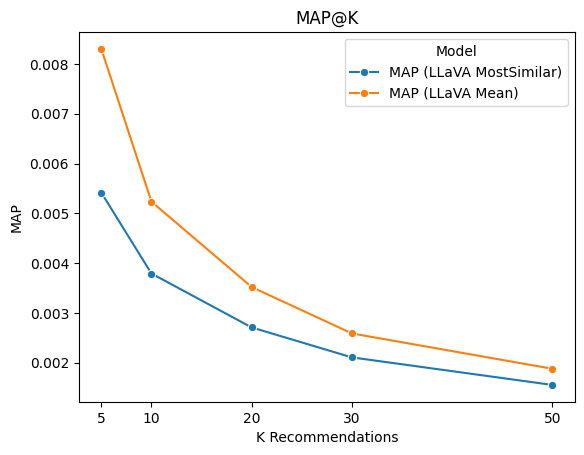

In [57]:
models = ['LLaVA (MostSimilar)', 'LLaVA (Mean)']

llava_mostsim_map_values, llava_mean_map_values = list(zip(*map_values))
df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'MAP (LLaVA MostSimilar)' : llava_mostsim_map_values,
    'MAP (LLaVA Mean)' : llava_mean_map_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='MAP'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='MAP', hue='Model', marker='o')
plt.title("MAP@K")
plt.xticks(k_values)
plt.show()

In [58]:
novelty_values = []
diversity_values = []

for k in k_values:
    novelty_llava_most_sim = novelty(global_llava_most_sim_reclists_k[k])
    diversity_llava_most_sim = diversity(global_llava_most_sim_reclists_k[k])

    novelty_llava_mean = novelty(global_llava_mean_reclists_k[k])
    diversity_llava_mean = diversity(global_llava_mean_reclists_k[k])

    novelty_values.append((novelty_llava_most_sim, novelty_llava_mean))
    diversity_values.append((diversity_llava_most_sim, diversity_llava_mean))

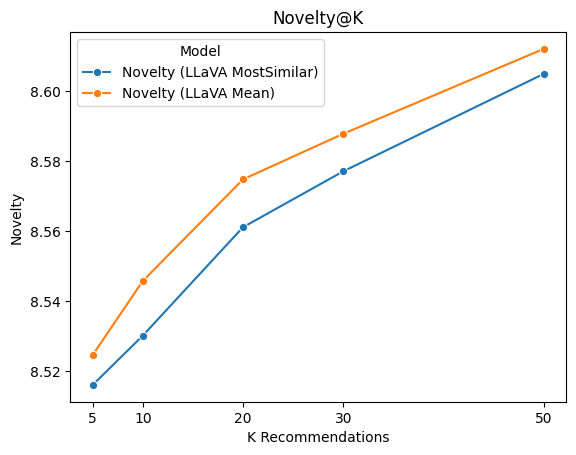

In [59]:
llava_mostsim_novelty_values, llava_mean_novelty_values = list(zip(*novelty_values))

df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Novelty (LLaVA MostSimilar)' : llava_mostsim_novelty_values,
    'Novelty (LLaVA Mean)' : llava_mean_novelty_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Novelty'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='Novelty', hue='Model', marker='o')
plt.title("Novelty@K")
plt.xticks(k_values)
plt.show()

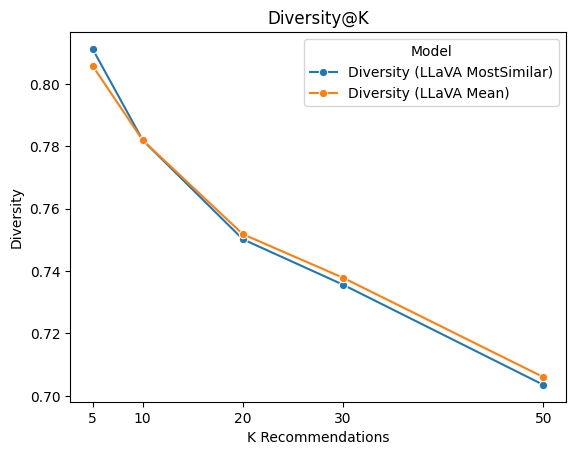

In [60]:
llava_mostsim_diversity_values, llava_mean_diversity_values = list(zip(*diversity_values))

df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Diversity (LLaVA MostSimilar)' : llava_mostsim_diversity_values,
    'Diversity (LLaVA Mean)' : llava_mean_diversity_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Diversity'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='Diversity', hue='Model', marker='o')
plt.title("Diversity@K")
plt.xticks(k_values)
plt.show()

# Results

## LLaVA - Most Similar

### Metrics

In [64]:
print('LLaVA (Case 1: Most Similar)')
llava_most_sim_reclist10, llava_most_sim_reclist20, llava_most_sim_reclist30 = {}, {}, {}

for user_id, reclists in llava_most_sim_reclist.items():
    llava_most_sim_reclist10[user_id] = reclists[10]
    llava_most_sim_reclist20[user_id] = reclists[20]
    llava_most_sim_reclist30[user_id] = reclists[30]


LLaVA (Case 1: Most Similar)


In [65]:
evaluate_model(llava_most_sim_reclist10, n=10)

MAP@10: 0.0037906137184115533
nDCG@10: 0.03650955665258289
Recall@10: 0.036101083032490974
Precision@10: 0.0037906137184115533
MRR@10: 0.02019655034095467
Novelty@10: 8.530155799314224
Diversity@10: 0.7819494584837541


In [66]:
evaluate_model(llava_most_sim_reclist20, n=20)

MAP@20: 0.0027075812274368243
nDCG@20: 0.05025169959981296
Recall@20: 0.048736462093862815
Precision@20: 0.002617328519855597
MRR@20: 0.021150430545723433
Novelty@20: 8.561162787036437
Diversity@20: 0.7501805054151622


In [67]:
evaluate_model(llava_most_sim_reclist30, n=30)

MAP@30: 0.002105896510228641
nDCG@30: 0.05562894081513639
Recall@30: 0.054211793020457276
Precision@30: 0.002045728038507822
MRR@30: 0.021521745116549258
Novelty@30: 8.577136887503992
Diversity@30: 0.7356197352587251


### Examples

In [70]:
# Buscamos diversos usuarios
user1, user2, user3 = None, None, None
while not (user1 and user2 and user3):
    for user, recs in test_users.items():
        if user1 == None and 1 <= len(recs) < 4:
            user1 = user
        if user2 == None and 4 <= len(recs) < 6:
            user2 = user
        if user3 == None and 8 <= len(recs):
            user3 = user

Recomendaciones realizadas con LLava Most Similar

#### User 1

In [100]:
# LLaVa Most Similar
show_recommendations(user=user1, reclist=llava_most_sim_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
2,Wimpy's,NaN,Restaurant;Hamburger restaurant
3,Soupa Blvd,NaN,Restaurant
4,Yogurtown Cafe,NaN,Dessert shop;Frozen yogurt shop;Dessert restau...
5,Ahi and Vegetable,NaN,Seafood restaurant;Seafood wholesaler
6,Koa Pancake House,Outpost of a small chain known for its relaxed...,Breakfast restaurant;Brunch restaurant
7,Souq Markets at Richmond Ave,NaN,Grocery store;Middle Eastern restaurant;Halal ...
8,Baja Fresh Mexican Grill,"Mexican fast-food chain featuring fish tacos, ...",Breakfast restaurant;Mexican restaurant;Spanis...
9,DJ's Drive In,NaN,American restaurant;Restaurant


In [101]:
show_recommendations(user=user1, reclist=llava_most_sim_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Layalina Resturant,NaN,Middle Eastern restaurant;Mediterranean restau...
2,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
3,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
4,Golden Spoon,NaN,Frozen yogurt shop;Ice cream shop;Restaurant
5,Wimpy's,NaN,Restaurant;Hamburger restaurant
6,Soupa Blvd,NaN,Restaurant
7,McDonald's - NEW LOCATION (next to Walgreen's)...,"Classic, long-running fast-food chain known fo...",Fast food restaurant
8,Yogurtown Cafe,NaN,Dessert shop;Frozen yogurt shop;Dessert restau...
9,Ahi and Vegetable,NaN,Seafood restaurant;Seafood wholesaler


#### User 2

In [102]:
show_recommendations(user=user2, reclist=llava_most_sim_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Kids' menu, Wine, Late-night food, Coffee
   Happy-hour drinks, Cocktails, Small plates, Comfort food, Vegetarian options
   Happy-hour food, Healthy options, Quick bite, Alcohol, Spirits

10 RECOMENDACIONES


,name,description,categories
0,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
1,Mogador Moroccan Bistro,NaN,Moroccan restaurant
2,Veritas Steak & Seafood,"Lakeside, upscale steakhouse serving up Americ...",Restaurant
3,Acapulco,NaN,Mexican restaurant
4,Buffet City,All-you-can-eat Chinese & Japanese restaurant ...,Sushi restaurant;Chinese restaurant;Buffet res...
5,Sarita's Restaurant,NaN,Salvadoran restaurant
6,city lights of china,NaN,Chinese restaurant
7,Sang Jun Thai Richmond,Classy spot for Thai fare & sushi in an intima...,Thai restaurant
8,Pine Grove Restaurant,NaN,American restaurant
9,Pino's Pizza & Italian Restaurant,NaN,Italian restaurant


In [104]:
show_recommendations(user=user2, reclist=llava_most_sim_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Kids' menu, Wine, Late-night food, Coffee
   Happy-hour drinks, Cocktails, Small plates, Comfort food, Vegetarian options
   Happy-hour food, Healthy options, Quick bite, Alcohol, Spirits

20 RECOMENDACIONES


,name,description,categories
0,La Rinconada Mexican Restaurant,NaN,Mexican restaurant
1,LA FLAMA @ Culver City,NaN,Restaurant
2,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
3,Vines Bistro,Casual eatery at Hyatt Regency hotel offering ...,Bistro;Restaurant
4,Mogador Moroccan Bistro,NaN,Moroccan restaurant
5,Friends & Family,NaN,Restaurant
6,Jersey Mike's Subs,New Jersey-based counter-serve sandwich chain ...,Caterer;Takeout Restaurant;Sandwich shop;Deli;...
7,Charlie's Main Street Cafe,Downtown icon serving homestyle American eats ...,American restaurant;Restaurant
8,Veritas Steak & Seafood,"Lakeside, upscale steakhouse serving up Americ...",Restaurant
9,Acapulco,NaN,Mexican restaurant


#### User 3

In [105]:
show_recommendations(user=user3, reclist=llava_most_sim_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Wine, Happy hour drinks, Happy hour food, Hard liquor
   Coffee, Cocktails, Small plates, Comfort food, Vegetarian options
   Kids' menu, Quick bite, Alcohol, Healthy options

10 RECOMENDACIONES


,name,description,categories
0,Paradise Dynasty,NaN,Chinese restaurant
1,Rikas Peruvian cuisine,NaN,Peruvian restaurant
2,Fugetsu - San Jose,NaN,Restaurant
3,New Belgium Brewing Taproom & Restaurant,NaN,Brewery;Californian restaurant;Restaurant
4,Mr. East Kitchen,NaN,Breakfast restaurant;Thai restaurant;Asian res...
5,Ultramen Japanese Ramen & Grill,NaN,Japanese restaurant
6,Flamingo Express,NaN,Obanzai restaurant;Restaurant
7,Bangkok Thai Cuisine,NaN,Thai restaurant
8,Hibiscus Thai Cuisine,Classic Thai fare & cocktails served in a rela...,Thai restaurant
9,Nisa Thai Cuisine 2,NaN,Thai restaurant


In [106]:
show_recommendations(user=user3, reclist=llava_most_sim_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Wine, Happy hour drinks, Happy hour food, Hard liquor
   Coffee, Cocktails, Small plates, Comfort food, Vegetarian options
   Kids' menu, Quick bite, Alcohol, Healthy options

20 RECOMENDACIONES


,name,description,categories
0,Bangkok Street Food,NaN,Thai restaurant;Restaurant
1,Paradise Dynasty,NaN,Chinese restaurant
2,Rikas Peruvian cuisine,NaN,Peruvian restaurant
3,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
4,Fugetsu - San Jose,NaN,Restaurant
5,Blazing Noodles | Pechanga Resort Casino,NaN,Chinese restaurant
6,New Belgium Brewing Taproom & Restaurant,NaN,Brewery;Californian restaurant;Restaurant
7,55 Thai Kitchen SDSU,NaN,Thai restaurant
8,Willow Garden,NaN,Chinese restaurant
9,Mr. East Kitchen,NaN,Breakfast restaurant;Thai restaurant;Asian res...


### Description Analysis

In [78]:
restaurants_descriptions = {}
for rev_id, description in rev_descriptions.items():

    rest_id = rev_id2info[rev_id]['rest_id']
    rest_name = restaurants_dict[rest_id]['name']

    if not restaurants_descriptions.get(rest_name):
        restaurants_descriptions[rest_name] = []

    restaurants_descriptions[rest_name].append(description)

In [79]:
def print_descriptions(reclist):

    for rest_id in reclist:
        rest_name = restaurants_dict[rest_id]['name']
        print('\n', rest_name.upper(), '\n')
        for desc in restaurants_descriptions[rest_name]:
            sentences = desc.split('.')
            for sentence in sentences:
                if len(sentence) > 100:
                    sentence = sentence.split(',')
                    for part in sentence:
                        print(part)
                else:
                    print(sentence)


        print('\n' * 1)
        print('-' * 100)

In [107]:
# Ejemplo de descripciones de restaurantes para el usuario 1
print_descriptions(llava_most_sim_reclist10[user1])


 BAJA FRESH MEXICAN GRILL 

The image features a storefront with a sign that reads "Bay fresh
" The sign is attached to a white pole, and it is positioned in front of a store window
 The store is located in a shopping center, as evidenced by the presence of cars parked outside


There are several cars parked in the parking lot
 with one car positioned near the left side of the image
 another car on the right side
 and two more cars parked in the middle of the scene
 Additionally, there is a truck parked in the parking lot on the right side



----------------------------------------------------------------------------------------------------

 SOUQ MARKETS AT RICHMOND AVE 

The image features a large building with a storefront that has a blue sign on it
 The store is called "Simply," and it appears to be a grocery store
 The building is surrounded by a parking lot, with several cars parked in the lot


There are multiple people in the scene
 some of them standing near the store
 while

Podemos notar que gran parte de las recomendaciones tienen en comun sobre restaurantes con un gran ambiente musical, con gente y buen ambiente. Si bien no es del mismo "tipo" (como comida mexicana, tailandesa, etc..), la descripcion de la imagen da implicitamente el gusto de la persona.

## LLaVA Mean

### Metrics

In [81]:
llava_mean_reclist10, llava_mean_reclist20 = {}, {}

for user_id, reclists in llava_mean_reclist.items():
    llava_mean_reclist10[user_id] = reclists[10]
    llava_mean_reclist20[user_id] = reclists[20]

In [82]:
evaluate_model(llava_mean_reclist10, n=10)

MAP@10: 0.005234657039711194
nDCG@10: 0.04483653714493931
Recall@10: 0.04422382671480144
Precision@10: 0.005054151624548739
MRR@10: 0.02937224227837946
Novelty@10: 8.54579321789936
Diversity@10: 0.7819494584837544


In [83]:
evaluate_model(llava_mean_reclist20, n=20)

MAP@20: 0.003519855595667872
nDCG@20: 0.059834227224937746
Recall@20: 0.05836341756919375
Precision@20: 0.0034296028880866445
MRR@20: 0.030456970140009892
Novelty@20: 8.574839579615794
Diversity@20: 0.7518050541516244


### Examples

#### User 1

Recomendaciones realizadas con LLaVA Mean

In [112]:
show_recommendations(user=user1, reclist=llava_mean_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
2,Wimpy's,NaN,Restaurant;Hamburger restaurant
3,Soupa Blvd,NaN,Restaurant
4,Yogurtown Cafe,NaN,Dessert shop;Frozen yogurt shop;Dessert restau...
5,Ahi and Vegetable,NaN,Seafood restaurant;Seafood wholesaler
6,Koa Pancake House,Outpost of a small chain known for its relaxed...,Breakfast restaurant;Brunch restaurant
7,Souq Markets at Richmond Ave,NaN,Grocery store;Middle Eastern restaurant;Halal ...
8,Baja Fresh Mexican Grill,"Mexican fast-food chain featuring fish tacos, ...",Breakfast restaurant;Mexican restaurant;Spanis...
9,DJ's Drive In,NaN,American restaurant;Restaurant


In [113]:
show_recommendations(user=user1, reclist=llava_mean_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Layalina Resturant,NaN,Middle Eastern restaurant;Mediterranean restau...
2,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
3,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
4,Golden Spoon,NaN,Frozen yogurt shop;Ice cream shop;Restaurant
5,Wimpy's,NaN,Restaurant;Hamburger restaurant
6,Soupa Blvd,NaN,Restaurant
7,McDonald's - NEW LOCATION (next to Walgreen's)...,"Classic, long-running fast-food chain known fo...",Fast food restaurant
8,Yogurtown Cafe,NaN,Dessert shop;Frozen yogurt shop;Dessert restau...
9,Ahi and Vegetable,NaN,Seafood restaurant;Seafood wholesaler


#### User 2

In [108]:
show_recommendations(user=user2, reclist=llava_mean_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Kids' menu, Wine, Late-night food, Coffee
   Happy-hour drinks, Cocktails, Small plates, Comfort food, Vegetarian options
   Happy-hour food, Healthy options, Quick bite, Alcohol, Spirits

10 RECOMENDACIONES


,name,description,categories
0,BurgerIM,NaN,Fast food restaurant;Hamburger restaurant;Rest...
1,Original Tommy's World Famous Hamburgers,NaN,American restaurant;Hamburger restaurant
2,Linden Public House II,NaN,Event venue;Restaurant;Pub
3,Diana's Mexican Cafe,NaN,Restaurant
4,Don Juanito,NaN,Mexican restaurant
5,Izzy’s Kitchen,NaN,Restaurant
6,Miller's Downtown,Old-school bar with a patio on the downtown ma...,Hamburger restaurant;Live music venue;Bar & gr...
7,Roger Brown's Restaurant and Sports Bar,Casual sports bar serving Southern-leaning com...,Sports bar;Seafood restaurant;Dance hall;Banqu...
8,The Pink Dinghy,NaN,Restaurant
9,Granny's Country Cooking/Sweet Spice Caribbean...,NaN,Barbecue restaurant;Restaurant


In [109]:
show_recommendations(user=user2, reclist=llava_mean_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Kids' menu, Wine, Late-night food, Coffee
   Happy-hour drinks, Cocktails, Small plates, Comfort food, Vegetarian options
   Happy-hour food, Healthy options, Quick bite, Alcohol, Spirits

20 RECOMENDACIONES


,name,description,categories
0,Charleys Cheesesteaks,Counter-service chain offering a range of Phil...,Food court;Cheesesteak restaurant;Sandwich sho...
1,BurgerIM,NaN,Fast food restaurant;Hamburger restaurant;Rest...
2,Original Tommy's World Famous Hamburgers,NaN,American restaurant;Hamburger restaurant
3,Carisoul BBQ,NaN,Caribbean restaurant
4,Cafe De Paris,NaN,Restaurant
5,Arroz Con Pollo,NaN,Dominican restaurant;Puerto Rican restaurant
6,Flambe After Dark,NaN,Restaurant
7,Paniolos Kapolei,NaN,Burrito restaurant;Mexican restaurant
8,Red barrel bar and grill,NaN,Karaoke;Bar & grill;Pool hall;Live music bar;R...
9,Darlene's Breakfast Cafe,NaN,Brunch restaurant


#### User 3

In [110]:
show_recommendations(user=user3, reclist=llava_mean_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Wine, Happy hour drinks, Happy hour food, Hard liquor
   Coffee, Cocktails, Small plates, Comfort food, Vegetarian options
   Kids' menu, Quick bite, Alcohol, Healthy options

10 RECOMENDACIONES


,name,description,categories
0,Evergreen Restaurant,American steak & seafood spot in a lodge-like ...,Fine dining restaurant;Steak house;Seafood res...
1,Keunjib Restaurant DINE IN,NaN,Korean restaurant
2,China Bowl Express,NaN,Chinese restaurant;Rice restaurant
3,CJ BBQ,"Both American & Korean BBQ, grilled meats & si...",Barbecue restaurant;American restaurant
4,Hula Fire Grill,NaN,Hawaiian restaurant
5,Season Buffet Chinese Restaurant,NaN,Takeout Restaurant;Delivery Chinese restaurant...
6,Chen's Kitchen Restaurant,"No-frills spot for basic Chinese fare, offerin...",Asian restaurant;Chinese restaurant;Restaurant
7,Maggie McFly's,Airy outpost of local chain bistro & bar with ...,Bar;Traditional American restaurant
8,Five Boroughs Restaurant,NaN,Restaurant
9,Grill Kabob of Dulles,Counter-serve restaurant offering made-to-orde...,Grill store;Afghani restaurant


In [111]:
show_recommendations(user=user3, reclist=llava_mean_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Beer, Wine, Happy hour drinks, Happy hour food, Hard liquor
   Coffee, Cocktails, Small plates, Comfort food, Vegetarian options
   Kids' menu, Quick bite, Alcohol, Healthy options

20 RECOMENDACIONES


,name,description,categories
0,Tasty Thousand Restaurant,NaN,Mandarin restaurant;Chinese restaurant;Soup re...
1,Evergreen Restaurant,American steak & seafood spot in a lodge-like ...,Fine dining restaurant;Steak house;Seafood res...
2,Keunjib Restaurant DINE IN,NaN,Korean restaurant
3,Silk Road,NaN,Asian restaurant;Halal restaurant
4,China Bowl Express,NaN,Chinese restaurant;Rice restaurant
5,CJ BBQ,"Both American & Korean BBQ, grilled meats & si...",Barbecue restaurant;American restaurant
6,Maile Chinese Restaurant,NaN,Chinese restaurant
7,Takenoko Sushi Llc,NaN,Sushi restaurant
8,Hula Fire Grill,NaN,Hawaiian restaurant
9,Season Buffet Chinese Restaurant,NaN,Takeout Restaurant;Delivery Chinese restaurant...


### Description Analysis

In [114]:
print_descriptions(llava_mean_reclist10[user1])


 BAJA FRESH MEXICAN GRILL 

The image features a storefront with a sign that reads "Bay fresh
" The sign is attached to a white pole, and it is positioned in front of a store window
 The store is located in a shopping center, as evidenced by the presence of cars parked outside


There are several cars parked in the parking lot
 with one car positioned near the left side of the image
 another car on the right side
 and two more cars parked in the middle of the scene
 Additionally, there is a truck parked in the parking lot on the right side



----------------------------------------------------------------------------------------------------

 SOUQ MARKETS AT RICHMOND AVE 

The image features a large building with a storefront that has a blue sign on it
 The store is called "Simply," and it appears to be a grocery store
 The building is surrounded by a parking lot, with several cars parked in the lot


There are multiple people in the scene
 some of them standing near the store
 while